# Capstone Project - Predict Forex Price
### Applied Data Science Certificate by https://csc.edu.vn/

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [EDA](#EDA)
* [Methodology](#methodology)
* [Feature Engineering](#FeatureEngineering)
* [Models:](#analysis)
    1.   [ARIMA](#ARIMA)
    2.   [LSTM](#LSTM)
    3.   [Prophet](#Prophet)
* [Conclusion](#Conclusions)
* [Future directions](#Futuredirections)


## Introduction: Business Problem <a name="introduction"></a>

In this project, we will try to create a predictive model with an essential Algorithmic Trading to support individual investors or financial businesses making a better transaction decision, forecast future movements in exchange rates using past market data, traders need to look for patterns and signals.

For study purpose, the scope of this project is mainly about finding out what should be a best model for specific usecases by comparision of evaluate coefficients.

We will look at patterns in data to determine if those patterns are likely to emerge again, which allows businesses and investors to adjust where they use their resources to take advantage of possible future events.

## Data <a name="data"></a>

Based on definition of our problem, factors that will effecting our 
decission are:

The daily, weeky, monthly & yearly differences between closing price of the Forex.
The diffences between the exchange rates of each country in Forex market all over the world come from different sectors. For example: International currency exchange rates display how much one unit of a currency can be exchanged for another currency.

I decided to use mainly the closing price for simplicity and to held remove some noise from daily volatility of the Forex price in general.

Following data sources will be needed to extract/generate the required information:

History Price of Forex can be obtained through this package: https://github.com/fxcm/RestAPI

In [1]:
#common
import datetime as dt
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import math
import warnings
warnings.filterwarnings('ignore') 
#Times Serries
from pandas.plotting import lag_plot
from datetime import datetime
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
#LSTM
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
#Prophet
from fbprophet import Prophet
#ARIMA
from pandas.plotting import autocorrelation_plot

In [2]:
# Get data from API package
import fxcmpy
TOKEN = 'ccf0e2248bf73ca5f37919cc53913fa67935cea4'
con = fxcmpy.fxcmpy(access_token=TOKEN, log_level='error', server='real')
print(con.get_instruments())

['EUR/USD', 'USD/JPY', 'GBP/USD', 'USD/CHF', 'EUR/CHF', 'AUD/USD', 'USD/CAD', 'NZD/USD', 'EUR/GBP', 'EUR/JPY', 'GBP/JPY', 'CHF/JPY', 'GBP/CHF', 'EUR/AUD', 'EUR/CAD', 'AUD/CAD', 'AUD/JPY', 'CAD/JPY', 'NZD/JPY', 'GBP/CAD', 'GBP/NZD', 'GBP/AUD', 'AUD/NZD', 'USD/SEK', 'EUR/SEK', 'EUR/NOK', 'USD/NOK', 'USD/MXN', 'AUD/CHF', 'EUR/NZD', 'USD/ZAR', 'USD/HKD', 'ZAR/JPY', 'USD/TRY', 'EUR/TRY', 'NZD/CHF', 'CAD/CHF', 'NZD/CAD', 'TRY/JPY', 'USD/ILS', 'USD/CNH', 'AUS200', 'ESP35', 'FRA40', 'GER30', 'HKG33', 'JPN225', 'NAS100', 'SPX500', 'UK100', 'US30', 'Copper', 'CHN50', 'EUSTX50', 'VOLX', 'USDOLLAR', 'US2000', 'USOil', 'UKOil', 'SOYF', 'NGAS', 'USOilSpot', 'UKOilSpot', 'WHEATF', 'CORNF', 'Bund', 'XAU/USD', 'XAG/USD', 'EMBasket', 'JPYBasket', 'BTC/USD', 'BCH/USD', 'ETH/USD', 'LTC/USD', 'XRP/USD', 'CryptoMajor', 'EOS/USD', 'XLM/USD', 'ESPORTS', 'BIOTECH', 'CANNABIS', 'FAANG', 'CHN.TECH', 'CHN.ECOMM', 'USEquities', 'BA.us', 'BAC.us', 'DIS.us', 'F.us', 'JPM.us', 'PFE.us', 'T.us', 'XOM.us', 'AAPL.us', '

In [3]:
start = dt.datetime(2010, 1, 1)
stop = dt.datetime(2020, 11, 25)
data = con.get_candles('EUR/USD', period='D1',start=start, stop=stop,columns=['asks', 'tickqty'])

In [4]:
data

,askopen,askclose,askhigh,asklow,tickqty
date,,,,,
2010-01-04 22:00:00,1.43332,1.44144,1.44563,1.42587,55015
2010-01-05 22:00:00,1.44144,1.43676,1.44845,1.43472,60382
2010-01-06 22:00:00,1.43676,1.44091,1.44357,1.42835,58258
2010-01-07 22:00:00,1.44091,1.43104,1.44476,1.43000,56049
2010-01-08 22:00:00,1.43104,1.44156,1.44399,1.42646,58253
...,...,...,...,...,...
2020-11-20 22:00:00,1.18776,1.18583,1.18915,1.18505,193200
2020-11-22 22:00:00,1.18581,1.18571,1.18608,1.18532,131
2020-11-23 22:00:00,1.18589,1.18421,1.19068,1.18006,213636


In [5]:
# Rename the columns
data.rename(columns = {'askopen':'open',
                       'askclose':'close',
                       'askhigh':'high',
                       'asklow':'low',
                       'tickqty':'volume'}, inplace = True) 

In [6]:
data.to_csv(r'EURUSD.csv')

In [7]:
data

,open,close,high,low,volume
date,,,,,
2010-01-04 22:00:00,1.43332,1.44144,1.44563,1.42587,55015
2010-01-05 22:00:00,1.44144,1.43676,1.44845,1.43472,60382
2010-01-06 22:00:00,1.43676,1.44091,1.44357,1.42835,58258
2010-01-07 22:00:00,1.44091,1.43104,1.44476,1.43000,56049
2010-01-08 22:00:00,1.43104,1.44156,1.44399,1.42646,58253
...,...,...,...,...,...
2020-11-20 22:00:00,1.18776,1.18583,1.18915,1.18505,193200
2020-11-22 22:00:00,1.18581,1.18571,1.18608,1.18532,131
2020-11-23 22:00:00,1.18589,1.18421,1.19068,1.18006,213636


In [8]:
X = data[['open','high' ,'low', 'volume']]  #independent columns
y = data.close   #target column i.e price range

In [9]:
y

date
2010-01-04 22:00:00    1.44144
2010-01-05 22:00:00    1.43676
2010-01-06 22:00:00    1.44091
2010-01-07 22:00:00    1.43104
2010-01-08 22:00:00    1.44156
                        ...   
2020-11-20 22:00:00    1.18583
2020-11-22 22:00:00    1.18571
2020-11-23 22:00:00    1.18421
2020-11-24 22:00:00    1.18981
2020-11-25 22:00:00    1.19204
Name: close, Length: 3235, dtype: float64

Looking good. So now we have more than 10 years price of the 'EUR/USD' in Forex market since 2010. The data have all the data for Open/High/Low/Close for ask price of every trading day. We also know the volume of traded of each trading day.

This concludes the data gathering phase - we're now ready to use this data for analysis to predict the Forex price.

## EDA <a name="EDA"></a>

[2.53409614e-04 6.72294170e-01 3.27320105e-01 1.32316196e-04]


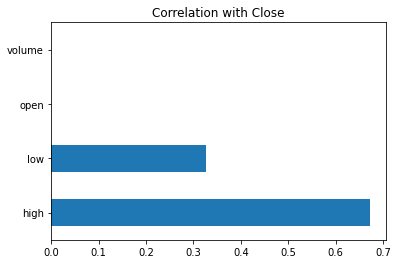

In [11]:
# Try to find out which are the important features
X = data[['open','high' ,'low', 'volume']]  #independent columns
y = data.close   #target column i.e price range
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
model = RandomForestRegressor()
model.fit(X,y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based regressor
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh', title='Correlation with Close')
plt.show()

In [12]:
data.shape

(3235, 5)

In [13]:
data.head(1)

,open,close,high,low,volume
date,,,,,
2010-01-04 22:00:00,1.43332,1.44144,1.44563,1.42587,55015


<AxesSubplot:xlabel='date'>

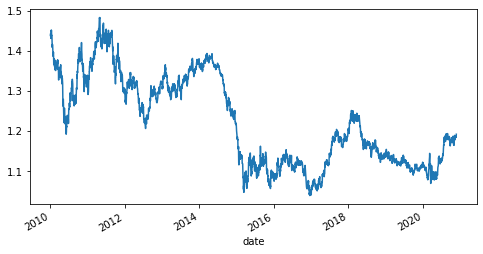

In [14]:
data.close.plot(figsize=(8,4))

The 'EUR/USD' exchange rate has some fluctuations in general longterm, it has some drop down period price in 2010, 2012, 2014 and recover slowly in the next years. Now the trend seems to be going up for the signal of recovery.

## Methodology <a name="methodology"></a>

In this project we will direct our efforts on predicting the trend and future value of the Forex price. We will focus on predict 'EUR/USD' exchange rate in the historical data.

In first step we have collected the required **data: historical price of 'EUR/USD' exchange rate  in more than the past 10 years**.

Second step in our analysis will be calculation and exploration of '**daily return**' and
 **volume change** to see if we can forecast anything about the Forex price.

In third and final step we will focus on building models from ARIMA to LSTM to Prophet to see which model may performed better.


## Feature Engineering <a name="FeatureEngineering"></a>

*   The **return**(daily): can help easier in mearsure the gain/loss at each day on the time-series much easier
* The  **vol_change**: It is important to look at the relationship between volume and price.  A price move, up or down, that is on higher volume is more significant.  Therefore, an analysis of price and volume allows the investor to better interpret the trends in price and any changes thereto.  In other words, volume gives an indication of the strength (momentum) of a move in price..[read more](https://www.rediff.com/money/special/trading-volume-what-it-reveals-about-the-market/20090703.htm#:~:text=It%20is%20important%20to%20look,higher%20volume%20is%20more%20significant.&text=An%20increasing%20price%20is%20typically,lose%20interest%20in%20the%20issue.)
 

In [15]:
data['returns'] = data['close'] / data['open']
#data['log_returns'] = data['returns'].apply(lambda x: math.log10(x))
data = data[['high', 'low', 'open', 'close', 'volume', 'returns']]

In [16]:
data.head()

,high,low,open,close,volume,returns
date,,,,,,
2010-01-04 22:00:00,1.44563,1.42587,1.43332,1.44144,55015,1.005665
2010-01-05 22:00:00,1.44845,1.43472,1.44144,1.43676,60382,0.996753
2010-01-06 22:00:00,1.44357,1.42835,1.43676,1.44091,58258,1.002888
2010-01-07 22:00:00,1.44476,1.43000,1.44091,1.43104,56049,0.993150
2010-01-08 22:00:00,1.44399,1.42646,1.43104,1.44156,58253,1.007351


In [17]:
data = data[data.volume != 0]

In [18]:
data.volume = data.volume.astype(float)
change = []
for a, b in zip(data.volume, data.volume[1:]):
    x = b-a
    change.append(x)

In [19]:
# changed
len(change)

3234

In [20]:
data.drop(data.index[0], inplace=True)
data.head()

,high,low,open,close,volume,returns
date,,,,,,
2010-01-05 22:00:00,1.44845,1.43472,1.44144,1.43676,60382.0,0.996753
2010-01-06 22:00:00,1.44357,1.42835,1.43676,1.44091,58258.0,1.002888
2010-01-07 22:00:00,1.44476,1.43000,1.44091,1.43104,56049.0,0.993150
2010-01-08 22:00:00,1.44399,1.42646,1.43104,1.44156,58253.0,1.007351
2010-01-11 22:00:00,1.45573,1.44096,1.44156,1.45152,52294.0,1.006909


In [21]:
data['vol_change'] = np.array(change)

In [22]:
data.describe()

,high,low,open,close,volume,returns,vol_change
count,3234.000000,3234.000000,3234.000000,3234.000000,3.234000e+03,3234.000000,3.234000e+03
mean,1.222142,1.213087,1.217759,1.217681,1.735281e+05,0.999954,5.462461e+01
std,0.111958,0.110311,0.111231,0.111162,1.348446e+05,0.005157,1.383126e+05
min,1.041910,1.034130,1.039160,1.039160,1.000000e+00,0.976224,-1.387291e+06
25%,1.123188,1.116287,1.119965,1.119965,8.352100e+04,0.997250,-2.829425e+04
50%,1.186070,1.178890,1.183120,1.183120,1.440095e+05,0.999977,3.111500e+03
75%,1.325457,1.315638,1.319830,1.319778,2.564458e+05,1.002628,4.187575e+04
max,1.494580,1.480500,1.483170,1.483170,1.470342e+06,1.030639,1.327870e+06


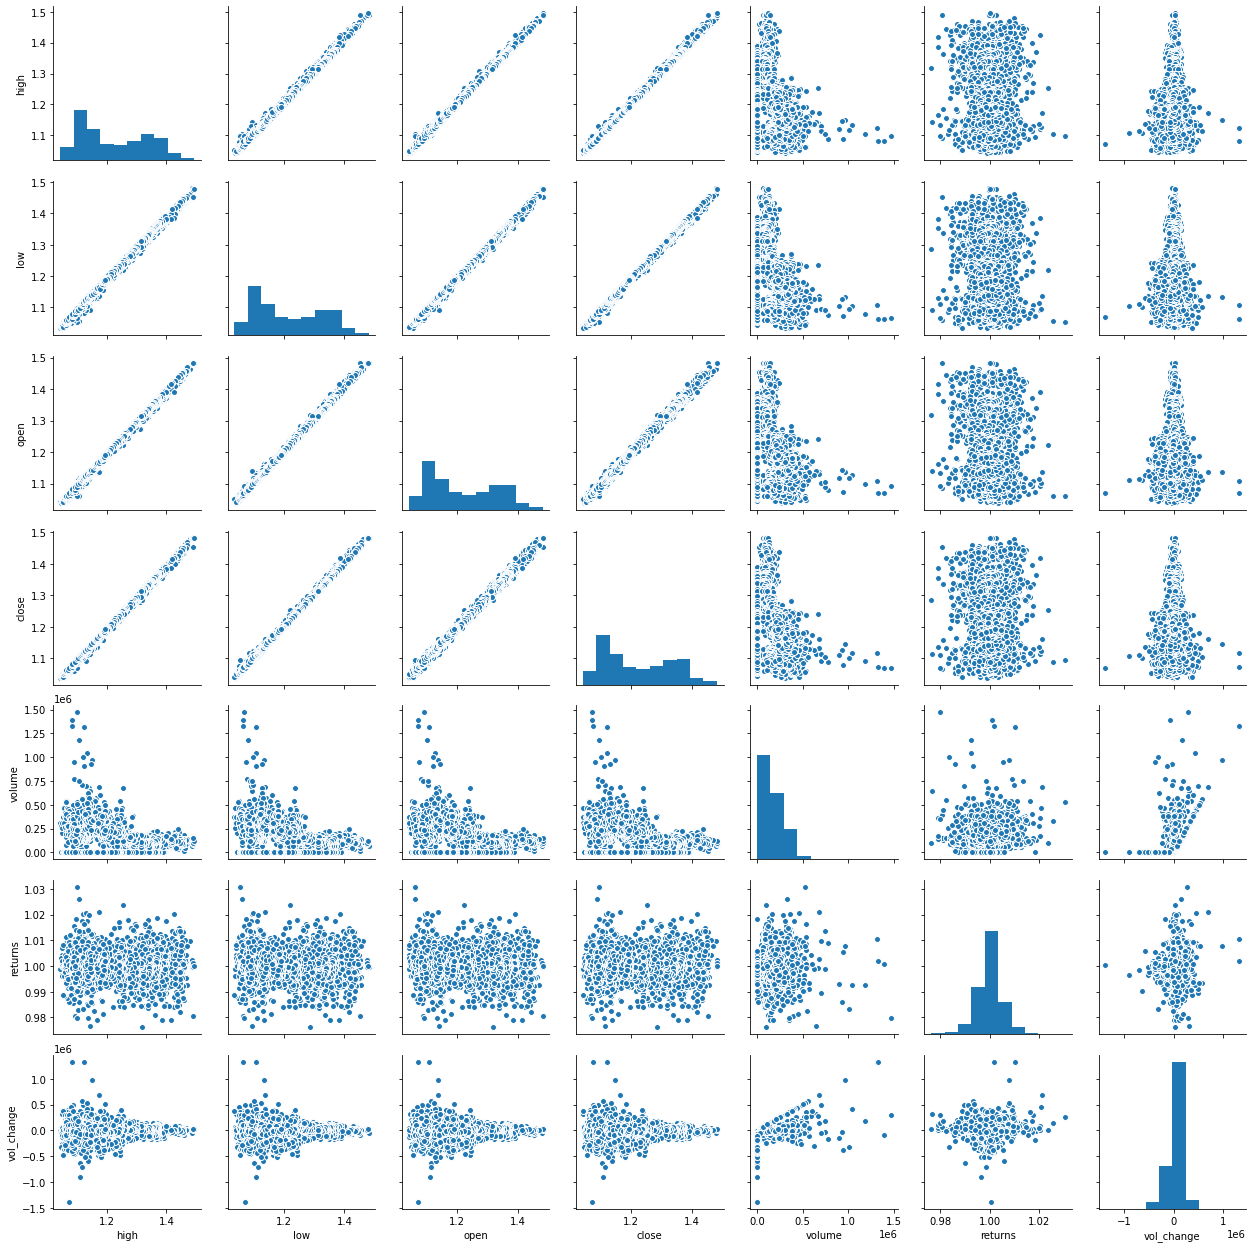

In [23]:
sns.pairplot(data)

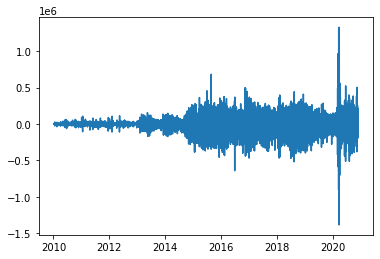

In [24]:
plt.plot(data.vol_change)

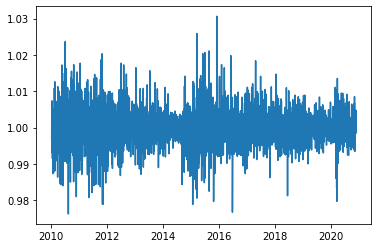

In [25]:
plt.plot(data.returns)

## Models: <a name="analysis"></a>

### ARIMA <a name="ARIMA"></a>

In [26]:
data.head()

,high,low,open,close,volume,returns,vol_change
date,,,,,,,
2010-01-05 22:00:00,1.44845,1.43472,1.44144,1.43676,60382.0,0.996753,5367.0
2010-01-06 22:00:00,1.44357,1.42835,1.43676,1.44091,58258.0,1.002888,-2124.0
2010-01-07 22:00:00,1.44476,1.43000,1.44091,1.43104,56049.0,0.993150,-2209.0
2010-01-08 22:00:00,1.44399,1.42646,1.43104,1.44156,58253.0,1.007351,2204.0
2010-01-11 22:00:00,1.45573,1.44096,1.44156,1.45152,52294.0,1.006909,-5959.0


In [27]:
data.index

DatetimeIndex(['2010-01-05 22:00:00', '2010-01-06 22:00:00',
               '2010-01-07 22:00:00', '2010-01-08 22:00:00',
               '2010-01-11 22:00:00', '2010-01-12 22:00:00',
               '2010-01-13 22:00:00', '2010-01-14 22:00:00',
               '2010-01-15 22:00:00', '2010-01-18 22:00:00',
               ...
               '2020-11-15 22:00:00', '2020-11-16 22:00:00',
               '2020-11-17 22:00:00', '2020-11-18 22:00:00',
               '2020-11-19 22:00:00', '2020-11-20 22:00:00',
               '2020-11-22 22:00:00', '2020-11-23 22:00:00',
               '2020-11-24 22:00:00', '2020-11-25 22:00:00'],
              dtype='datetime64[ns]', name='date', length=3234, freq=None)

In [28]:
data.index = pd.to_datetime(data.index).date

In [29]:
data.index

Index([2010-01-05, 2010-01-06, 2010-01-07, 2010-01-08, 2010-01-11, 2010-01-12,
       2010-01-13, 2010-01-14, 2010-01-15, 2010-01-18,
       ...
       2020-11-15, 2020-11-16, 2020-11-17, 2020-11-18, 2020-11-19, 2020-11-20,
       2020-11-22, 2020-11-23, 2020-11-24, 2020-11-25],
      dtype='object', length=3234)

In [30]:
data.head()

,high,low,open,close,volume,returns,vol_change
2010-01-05,1.44845,1.43472,1.44144,1.43676,60382.0,0.996753,5367.0
2010-01-06,1.44357,1.42835,1.43676,1.44091,58258.0,1.002888,-2124.0
2010-01-07,1.44476,1.43000,1.44091,1.43104,56049.0,0.993150,-2209.0
2010-01-08,1.44399,1.42646,1.43104,1.44156,58253.0,1.007351,2204.0
2010-01-11,1.45573,1.44096,1.44156,1.45152,52294.0,1.006909,-5959.0


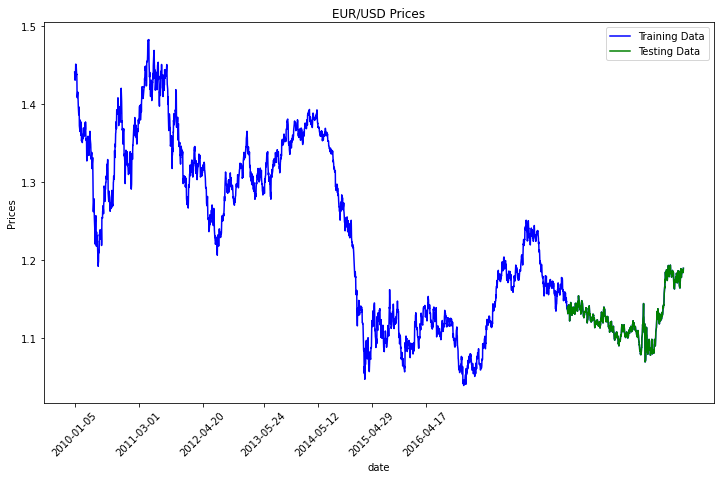

In [31]:
train_data, test_data = data[0:int(len(data)*0.8)], data[int(len(data)*0.8):]
plt.figure(figsize=(12,7))
plt.title('EUR/USD Prices')
plt.xlabel('date')
plt.ylabel('Prices')
plt.plot(data['open'], 'blue', label='Training Data')
plt.plot(test_data['open'], 'green', label='Testing Data')
plt.xticks( data.index[0:1857:300],rotation=45)
plt.legend()

In [32]:
train_ar = train_data['open'].values
test_ar = test_data['open'].values

history = [x for x in train_ar]
predictions = list()
for t in range(len(test_ar)):
    model = ARIMA(history, order=(2,1,0)) 
    model_fit = model.fit(disp=0, method = 'css')
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test_ar[t]
    history.append(obs)
    #print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test_ar, predictions)
print('Testing Mean Squared Error: %.8f' % error)

Testing Mean Squared Error: 0.00001676


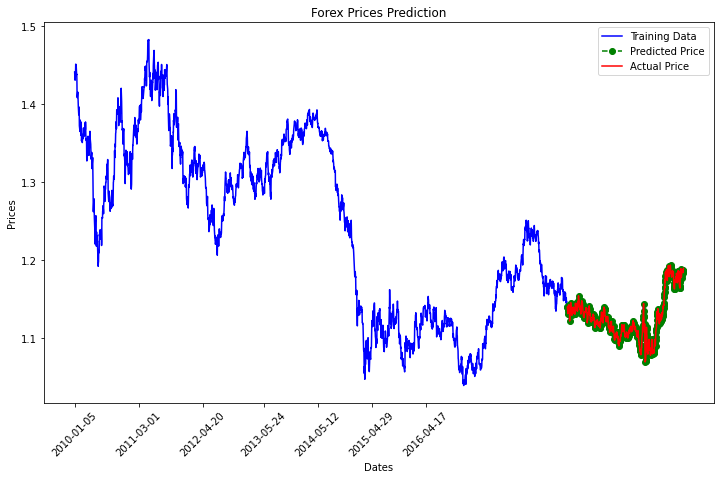

In [33]:
plt.figure(figsize=(12,7))
plt.plot(data['open'], 'green', color='blue', label='Training Data')
plt.plot(test_data.index, predictions, color='green', marker='o', linestyle='dashed', 
         label='Predicted Price')
plt.plot(test_data.index, test_data['open'], color='red', label='Actual Price')
plt.title('Forex Prices Prediction')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.xticks(data.index[0:1857:300],rotation=45)
plt.legend()

In [34]:
# Root Mean Squared Error
rmse = np.sqrt(np.mean(predictions-test_ar)**2) 
rmse

0.0001843005729657954

In [35]:
model_fit.save('model.pkl')

### LSTM <a name="LSTM"></a>

In [36]:
df = pd.DataFrame(data.close)
dataset = df.values
training_data_len = math.ceil(len(dataset)*0.8)
training_data_len

2588

In [37]:
df[0:training_data_len]

,close
2010-01-05,1.43676
2010-01-06,1.44091
2010-01-07,1.43104
2010-01-08,1.44156
2010-01-11,1.45152
...,...
2018-10-24,1.13932
2018-10-25,1.13756
2018-10-26,1.14058
2018-10-28,1.13948


In [38]:
test = df[training_data_len:]
test

,close
2018-10-30,1.13459
2018-10-31,1.13139
2018-11-01,1.14098
2018-11-02,1.13898
2018-11-04,1.13889
...,...
2020-11-20,1.18583
2020-11-22,1.18571
2020-11-23,1.18421
2020-11-24,1.18981


In [39]:
#scaling
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)
scaled_data

array([[0.89547533],
       [0.90482196],
       [0.88259273],
       ...,
       [0.32668183],
       [0.33929416],
       [0.34431657]])

In [40]:
train_data = scaled_data[0:training_data_len,:]
x_train  = []
y_train  = []
for i in range(60, len(train_data)):
  x_train.append(train_data[i-60:i,0])
  y_train.append(train_data[i,0])
  if i<=60:
    print(x_train,y_train)

[array([0.89547533, 0.90482196, 0.88259273, 0.90628589, 0.92871782,
       0.92261436, 0.92804216, 0.92606022, 0.89826806, 0.89982208,
       0.87790816, 0.83705322, 0.83221099, 0.8484944 , 0.84725569,
       0.82962095, 0.81849508, 0.80707642, 0.78236977, 0.79757213,
       0.80504944, 0.78912637, 0.7507939 , 0.73710052, 0.73412761,
       0.76746019, 0.75421725, 0.74396973, 0.72671787, 0.72291165,
       0.76151438, 0.72466836, 0.7070111 , 0.72169546, 0.7219432 ,
       0.70223644, 0.709466  , 0.71131281, 0.72633499, 0.71406049,
       0.72628995, 0.74464539, 0.71870003, 0.72739353, 0.73077183,
       0.72324948, 0.73577172, 0.74126709, 0.75921713, 0.73973559,
       0.7619423 , 0.75302358, 0.72464584, 0.70824981, 0.71374519,
       0.70009684, 0.65861129, 0.649107  , 0.68275489, 0.69644828])] [0.680975653701493]


In [41]:
valid_data = scaled_data[training_data_len:,:]
x_valid  = []
y_valid  = []
for i in range(60, len(valid_data)):
  x_valid.append(valid_data[i-60:i,0])
  y_valid.append(valid_data[i,0])
  if i<=60:
    print(x_valid,y_valid)

[array([0.21492759, 0.20772055, 0.22931916, 0.22481476, 0.22461206,
       0.22909394, 0.23348573, 0.23328303, 0.21904912, 0.21285557,
       0.21026553, 0.18645976, 0.20303597, 0.2074728 , 0.21154929,
       0.23139118, 0.23076057, 0.23994955, 0.22062566, 0.22420666,
       0.22859845, 0.21382401, 0.21447715, 0.21114389, 0.20299092,
       0.21961217, 0.22607599, 0.20963492, 0.21715727, 0.21704466,
       0.21470237, 0.21481498, 0.22254003, 0.22643634, 0.22589581,
       0.21758519, 0.20866647, 0.2201527 , 0.21805815, 0.20623409,
       0.20589626, 0.2154456 , 0.2186212 , 0.22217968, 0.23780996,
       0.22100854, 0.22130132, 0.22808045, 0.21693205, 0.23470192,
       0.23735952, 0.23623342, 0.23747213, 0.21470237, 0.22591834,
       0.22708948, 0.2273147 , 0.24418369, 0.2367289 , 0.25945362])] [0.24981419337402277]


In [42]:
x_train, y_train = np.array(x_train), np.array(y_train)
x_valid, y_valid = np.array(x_valid), np.array(y_valid)

In [43]:
# reshape to 3 dimension for LSTM
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1],1))
x_train.shape

(2528, 60, 1)

In [44]:
x_valid = np.reshape(x_valid, (x_valid.shape[0], x_valid.shape[1],1))
x_valid.shape

(586, 60, 1)

In [45]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1, activation='relu'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 50)            10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


In [46]:
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
early_stop = EarlyStopping(monitor='loss', patience=10, verbose=1)
model.compile(loss='mean_squared_error', optimizer='adam')

In [47]:
history = model.fit(
    x_train, y_train,
    validation_data = (x_valid, y_valid),
    epochs = 200,
    batch_size=8,
    verbose=1,
    shuffle=False,
    callbacks=[early_stop]
)

Epoch 1/200
316/316 [==============================] - 7s 21ms/step - loss: 0.0083 - val_loss: 0.0013
Epoch 2/200
316/316 [==============================] - 6s 19ms/step - loss: 0.0044 - val_loss: 0.0017
Epoch 3/200
316/316 [==============================] - 6s 19ms/step - loss: 0.0046 - val_loss: 0.0018
Epoch 4/200
316/316 [==============================] - 6s 19ms/step - loss: 0.0038 - val_loss: 0.0018
Epoch 5/200
316/316 [==============================] - 6s 19ms/step - loss: 0.0040 - val_loss: 0.0021
Epoch 6/200
316/316 [==============================] - 6s 19ms/step - loss: 0.0039 - val_loss: 0.0020
Epoch 7/200
316/316 [==============================] - 6s 19ms/step - loss: 0.0039 - val_loss: 0.0018
Epoch 8/200
316/316 [==============================] - 6s 19ms/step - loss: 0.0032 - val_loss: 0.0016
Epoch 9/200
316/316 [==============================] - 6s 19ms/step - loss: 0.0030 - val_loss: 0.0013
Epoch 10/200
316/316 [==============================] - 6s 19ms/step - loss: 0.002

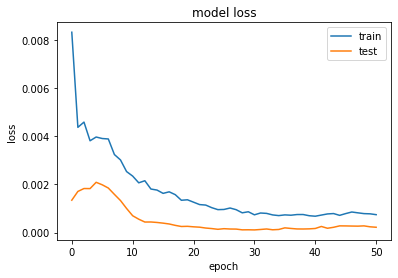

In [48]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'])

In [49]:
test_data = scaled_data[training_data_len-60: , :]
x_test = []
y_test = dataset[training_data_len:,:]
for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i,0])

In [50]:
x_test = np.array(x_test)

In [51]:
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1],1))

In [52]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

In [53]:
rmse = np.sqrt(np.mean(predictions-y_test)**2)
rmse

0.0007829653474790023

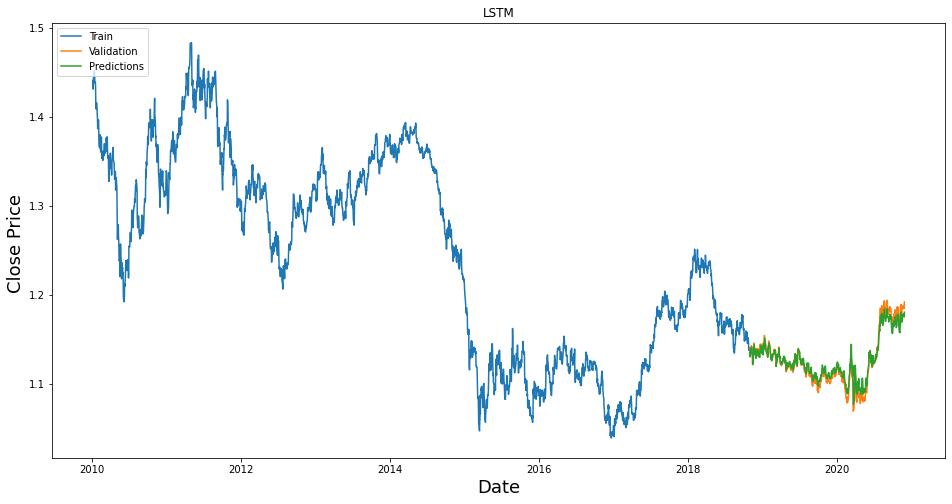

In [54]:
train = df[:training_data_len]
valid = df[training_data_len:]
valid['Predictions'] = predictions

plt.figure(figsize=(16,8))
plt.title('LSTM')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price ', fontsize=18)
plt.plot(train['close'])
plt.plot(valid[['close', 'Predictions']])
plt.legend(['Train', 'Validation', 'Predictions'], loc='upper left')

In [55]:
new_df = df
last_60_days = new_df[-60:].values
last_60_days_scaled = scaler.transform(last_60_days)
X_test=[]
X_test.append(last_60_days_scaled)
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))
pred_price = model.predict(X_test)
pred_price = scaler.inverse_transform(pred_price)
pred_price 

array([[1.1824547]], dtype=float32)

In [56]:
df.tail(10)

,close
2020-11-15,1.18452
2020-11-16,1.18544
2020-11-17,1.18644
2020-11-18,1.18549
2020-11-19,1.18776
2020-11-20,1.18583
2020-11-22,1.18571
2020-11-23,1.18421
2020-11-24,1.18981
2020-11-25,1.19204


### Prophet <a name="Prophet"></a>

In [57]:
df = df.reset_index()
df = df.rename(columns={"index":'ds',"close":"y"})
df

,ds,y
0,2010-01-05,1.43676
1,2010-01-06,1.44091
2,2010-01-07,1.43104
3,2010-01-08,1.44156
4,2010-01-11,1.45152
...,...,...
3229,2020-11-20,1.18583
3230,2020-11-22,1.18571
3231,2020-11-23,1.18421
3232,2020-11-24,1.18981


In [58]:
model = Prophet()
model.fit(df)

|INFO|2020-11-28 20:33:51,915|Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [59]:
future = model.make_future_dataframe(periods=365)
future.tail()

,ds
3594,2021-11-21
3595,2021-11-22
3596,2021-11-23
3597,2021-11-24
3598,2021-11-25


In [60]:
forecast = model.predict(future)

In [61]:
#forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2010-01-05,1.428674,1.399922,1.458174
1,2010-01-06,1.427493,1.398623,1.455481
2,2010-01-07,1.426501,1.398166,1.453873
3,2010-01-08,1.425588,1.395136,1.456287
4,2010-01-11,1.422502,1.395533,1.450085


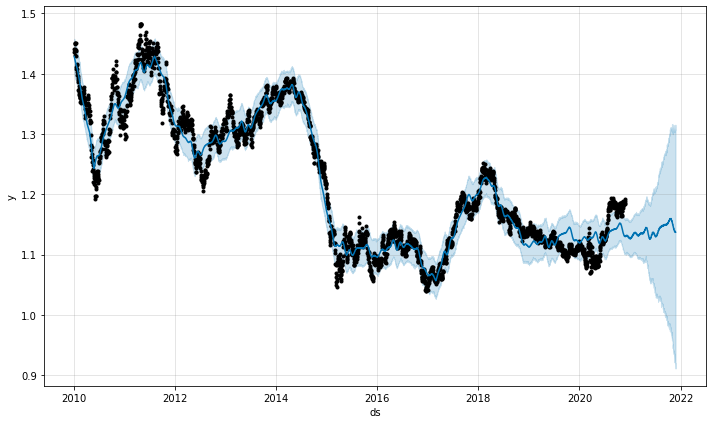

In [62]:
plot1 = model.plot(forecast)

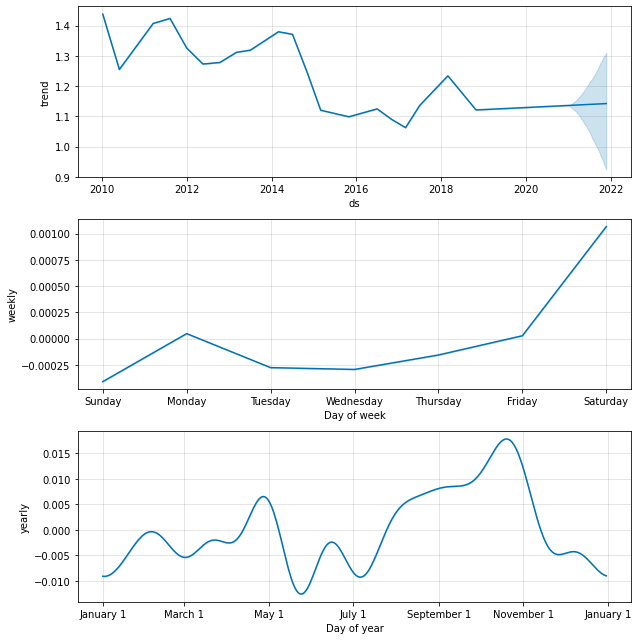

In [63]:
plot2 = model.plot_components(forecast)

In [64]:
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(model, initial='730 days', period='180 days', horizon = '365 days')
df_cv.head()

|INFO|2020-11-28 20:34:09,769|Making 17 forecasts with cutoffs between 2012-01-07 00:00:00 and 2019-11-26 00:00:00


packet queue is empty, aborting
|ERROR|2020-11-28 20:35:40,931|packet queue is empty, aborting


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2012-01-09,1.299864,1.279939,1.319910,1.27662,2012-01-07
1,2012-01-10,1.301526,1.281686,1.321942,1.27788,2012-01-07
2,2012-01-11,1.302537,1.283131,1.321848,1.27076,2012-01-07
3,2012-01-12,1.305113,1.286072,1.324027,1.28158,2012-01-07
4,2012-01-13,1.306849,1.286045,1.326777,1.26792,2012-01-07


In [65]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p

,horizon,mse,rmse,mae,mape,mdape,coverage
0,38 days,0.002016,0.044904,0.037978,0.032718,0.029919,0.345445
1,39 days,0.002077,0.045573,0.038608,0.033240,0.031636,0.341040
2,40 days,0.002119,0.046035,0.039063,0.033609,0.032780,0.337335
3,41 days,0.002190,0.046802,0.039764,0.034191,0.033017,0.332370
4,42 days,0.002246,0.047397,0.040267,0.034598,0.033437,0.331110
...,...,...,...,...,...,...,...
323,361 days,0.030122,0.173557,0.138957,0.118737,0.107285,0.873988
324,362 days,0.030134,0.173591,0.139005,0.118780,0.106616,0.876135
325,363 days,0.030166,0.173682,0.139135,0.118954,0.106600,0.877842
326,364 days,0.030046,0.173338,0.138696,0.118573,0.106616,0.882852


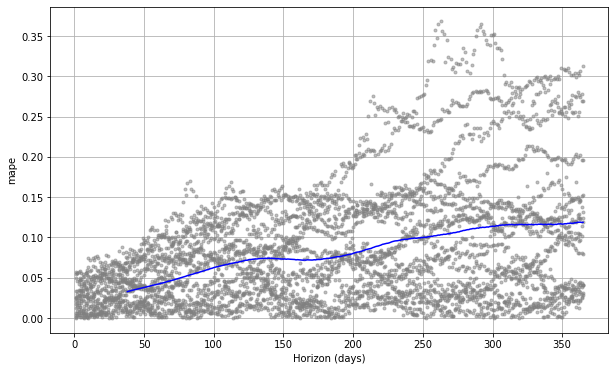

In [66]:
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mape')

In [67]:
rmse = np.sqrt(np.mean(df_cv.yhat-df_cv.y)**2) 
rmse

0.010110076827560047

## Conclusion

These model can be helpful for individual or organizational users in some cases, it help to see the vision and improving the ability to make a decision before transactions. We should not look at the small value of MSE or RMSE to enhence the belief in models because the change in price too small could let us lose a lot of pips in each transactions

## Future directions <a name="Futuredirections"></a>

We can run the model for all the money exchange rates in the world Forex market list to see which model performed best on which sector of the economy for example: ARIMA may be good at predicting Forex price of the specific money (EU/USD, GBP/USD..). But Prophet or LSTM may be better in others like Gold, Oil,...